In [1]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Gráficos
# ==============================================================================
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.metrics import accuracy_score

Importo en un dataframe la cohorte de datos

In [2]:
df_data = pd.read_csv('./data/data.csv', sep = ";")
df_data.index.name = 'idMuestra'
df_data.head(3)

,IDInm,NH,AntiN,AntiS,AntiM,age,gender,score,Line Timepoint,Timepoint,...,TH27p28n,TH27n28n,CTLDRn38n,CTLDRp38n,CTLDRn38p,CTLDRp38p,THDRn38n,THDRp38n,THDRn38p,THDRp38
idMuestra,,,,,,,,,,,,,,,,,,,,,
0,1407962,3084327,NaN,NaN,NaN,88,1,NaN,NaN,0.0,...,0.007514,0.037952,0.075808,0.064660,0.638796,0.220736,0.046994,0.024834,0.879776,0.048395
1,1407963,587116,NaN,NaN,NaN,46,0,NaN,NaN,0.0,...,0.001384,0.000951,0.057471,0.014049,0.826309,0.102171,0.035378,0.003979,0.938587,0.022057
2,1408025,764584,NaN,NaN,NaN,82,0,3.0,1.0,1.0,...,0.027458,0.085781,0.232804,0.037037,0.221164,0.508995,0.255428,0.018838,0.628991,0.096743


Escojo las variables que quiero utilizar y las meto en otro dataframe

In [3]:
df_datos = df_data[['score','age','ferritina','DimD','LINF ABS','C4','MoNOclasicos','TH27n28n']]

df_datos.head(3)

,score,age,ferritina,DimD,LINF ABS,C4,MoNOclasicos,TH27n28n
idMuestra,,,,,,,,
0,NaN,88,NaN,NaN,1000.0,45.68,0.098390,0.037952
1,NaN,46,NaN,14875.0,1791.0,36.57,0.090516,0.000951
2,3.0,82,328.0,276.0,1611.0,52.16,0.020647,0.085781


Compruebo el número de nulos (NaN) de cada variable

In [4]:
df_datos.isnull().sum()

score           261
age               0
ferritina       155
DimD            147
LINF ABS          4
C4               63
MoNOclasicos    102
TH27n28n         70
dtype: int64

<AxesSubplot:ylabel='idMuestra'>

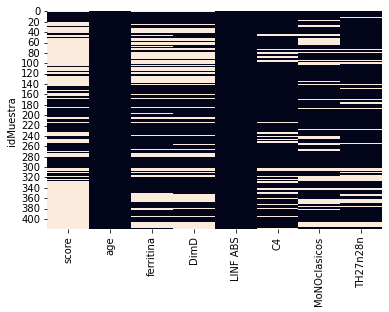

In [5]:
# Identificamos los valores NaN visualmente
sns.heatmap(df_datos.isnull(), cbar=False)

Creo otro dataframe sin valores nulos (NaN)

In [6]:
df_sinNaN = df_datos.copy()
for i in range(df_sinNaN.shape[1]):
    df_sinNaN = df_sinNaN[~df_sinNaN[df_sinNaN.columns[i]].isnull()]
df_sinNaN.head(200)

,score,age,ferritina,DimD,LINF ABS,C4,MoNOclasicos,TH27n28n
idMuestra,,,,,,,,
2,3.0,82,328.0,276.0,1611.0,52.16,0.020647,0.085781
3,4.0,72,833.0,4654.0,687.0,15.56,0.046393,0.134451
4,1.0,51,1261.0,511.0,803.0,42.02,0.039211,0.001869
5,1.0,63,704.0,392.0,1131.0,39.76,0.039648,0.016114
6,1.0,54,452.0,790.0,1652.0,31.94,0.114563,0.008209
...,...,...,...,...,...,...,...,...
302,3.0,72,798.0,7508.0,1029.0,27.96,0.005609,0.115530
309,4.0,64,1154.0,724.0,795.0,53.90,0.005397,0.273622
312,5.0,76,836.0,351.0,639.0,52.94,0.018221,0.007921


Vamos a ver si nos quedó algún valor nulo:

In [7]:
df_sinNaN.isnull().sum()

score           0
age             0
ferritina       0
DimD            0
LINF ABS        0
C4              0
MoNOclasicos    0
TH27n28n        0
dtype: int64

Convierto la multivariable score en 2 variables: 0 Leve y 1 Moderado/Severo

In [8]:
df_sinNaN['score'] = np.where(df_sinNaN['score'] > 2, 1, 0)

print("Número de observaciones por clase")
print(df_sinNaN['score'].value_counts())
print("")

print("Porcentaje de observaciones por clase")
print(100 * df_sinNaN['score'].value_counts(normalize=True))

Número de observaciones por clase
0    90
1    27
Name: score, dtype: int64

Porcentaje de observaciones por clase
0    76.923077
1    23.076923
Name: score, dtype: float64


Creo los dataframes de entrenamiento (X) y de test (y)

In [9]:
X = df_sinNaN.drop(columns = 'score').to_numpy()
y = df_sinNaN['score'].to_numpy()

Validación cruzada con StratifiedKFold

In [10]:
def evalua(X,y,clasificador,repeticiones,folds):
    '''
    Función de ejemplo que evalua accuracy_score siguiendo un esquema
    de repeticiones y número de folds indicado.
    
    Podría modificarse para guardar predicciones o para evaluar otras medidas
    
    '''
    
    # se hacen 'repeticiones' validaciones cruzadas
    accs = []
    
    # se hace el proceso 'repeticiones' veces
    for i in range(repeticiones):
        
        # se usa StratifiedKFold varias veces, cada vez con una semilla distinta
        skf = StratifiedKFold(n_splits=folds,random_state=i, shuffle = True)
        
        
        for train_index, test_index in skf.split(X, y):
            
            # se crea multiples versiones de los conjuntos de entrenamiento y test
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            # entrenamos y evaluamos el clasificador
            clasificador.fit(X_train,y_train)
            y_pred = clasificador.predict(X_test)
            ### podría guardar las predicciones para más adelante si quisiera
            
            acc = accuracy_score(y_test, y_pred)
            accs.append(acc)
            
    # devolvemos la media de las repeticiones y folds
    return np.array(accs).mean() * 100

In [11]:
modeloLR = LogisticRegression(max_iter = 500)

In [12]:
print(round(evalua(X, y, modeloLR, 5, 2), 2), '%')
print(round(evalua(X, y, modeloLR, 10, 10), 2), '%')

75.21 %
76.3 %


In [13]:
modeloLR.fit(X,y)

LogisticRegression(max_iter=500)

Vamos a obtener el nombre de las columnas para que se vean en la tabla de coeficientes

In [14]:
att_names = []
for i in range(df_sinNaN.shape[1]):
    att_names.append(df_sinNaN.columns[i])
att_names.remove('score')

Sacamos la tabla de coeficientes del Logistic Regression:

In [15]:
log_odds = modeloLR.coef_[0]

df = pd.DataFrame(log_odds, 
             att_names, 
             columns=['Coeficientes'])

df.sort_values(by='Coeficientes', ascending=False)

,Coeficientes
MoNOclasicos,0.360114
age,0.054551
C4,0.044540
ferritina,0.000426
DimD,0.000382
LINF ABS,-0.000546
TH27n28n,-0.755528


Hallamos el coeficiente de interceptación:

In [16]:
beta0 = modeloLR.intercept_
print("Intercept (β0):", beta0)

Intercept (β0): [-6.56141125]


Al ser negativo, la probabilidad de obtener un resultado es menor que 0,5. Con la siguiente fórmula, calculamos la probabilidad cuando el score es 0:  
$$P = {e^{β_0} \over (1 + e^{β_0})}$$

In [17]:
p = np.exp(beta0) / (1 + np.exp(beta0))
p[0]

0.001411892686515634